# Лабораторная работа 4
Деревья решений

Выполнила: Кривоконева Екатерина, группа 6133

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

import warnings
import sys  
warnings.simplefilter("ignore")

## 1. Загрузка датасета

In [ ]:
data = pd.read_csv('data/googleplaystore.csv')
data.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


`googleplaystore.csv` содержит подробную информацию о приложениях в Google Play. 

Числовые признаки:

- Rating - Общий пользовательский рейтинг приложения 
- Reviews - Количество отзывов пользователей о приложении 

Категориальные признаки:

- App - Название приложения
- Category - Категория, к которой относится приложение
- Size - Размер приложения 
- Installs - Количество загрузок/установок приложения пользователями 
- Type - Платный или бесплатный
- Price - Стоимость приложения 
- Content - Возрастная группа, на которую ориентировано приложение
- Genres - Жанр приложения (помимо основной категории)

Ссылка на датасет: https://www.kaggle.com/lava18/google-play-store-apps



### Предобработка данных

Заменим Nan в столбце Rating средним значением по этому признаку:

In [ ]:
data.Rating = data.Rating.fillna(data.Rating.mean())

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          10841 non-null  float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


Далее добавим еще немного числовых признаков. 

Удалим строки которые содержат ошибочные значения: 

In [ ]:
idx_list = []

for i in range(data.shape[0]):
  if not data.iloc[i, data.columns.get_loc('Reviews')].isdigit():
    idx_list.append(i)

data = data.drop(data.index[idx_list])
data.Reviews = data.Reviews.astype('int')

Уберем знак доллара и оставим только цену в долларах:

In [ ]:
data.Price = data.Price.apply(lambda x: x.replace('$',''))
data.Price = data.Price.astype('float32')

Возьмем в качестве значений столбца Installs числа без плюса:

In [ ]:
data.Installs = data.Installs.apply(lambda x: x.split('+')[0])
data.Installs = data.Installs.apply(lambda x: x.replace(',',''))
data.Installs = data.Installs.astype('int')

Превратим значения из Size в числа с плавающей точкой:

In [ ]:
modified_size = []
for item in list(data.Size):
    if "M" in item:
        modified_size.append(float(item.upper().split("M")[0]))
    elif "K" in item:
        modified_size.append(float(item.upper().split("K")[0]) / 0.001)
    else:
        modified_size.append(0.0)
data['Size'] = modified_size

data.Size = data.Size.astype('float32')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10840 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10840 non-null  object 
 1   Category        10840 non-null  object 
 2   Rating          10840 non-null  float64
 3   Reviews         10840 non-null  int64  
 4   Size            10840 non-null  float32
 5   Installs        10840 non-null  int64  
 6   Type            10839 non-null  object 
 7   Price           10840 non-null  float32
 8   Content Rating  10840 non-null  object 
 9   Genres          10840 non-null  object 
 10  Last Updated    10840 non-null  object 
 11  Current Ver     10832 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float32(2), float64(1), int64(2), object(8)
memory usage: 1.1+ MB


In [ ]:
data.isna().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              1
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       8
Android Ver       2
dtype: int64

## 1.0. Для вашего датасета преобразовать категориальные признаки в бинарные с помощью pd.factorize / pd.get_dummies

In [ ]:
df = data.drop(columns=['Category', 'Type', 'Content Rating', 'Android Ver'])

In [ ]:
df = pd.concat([df, pd.get_dummies(data['Category'], drop_first = True)], axis = 1)
df = pd.concat([df, pd.get_dummies(data['Type'], drop_first = True)], axis = 1)
df = pd.concat([df, pd.get_dummies(data['Content Rating'], drop_first = True)], axis = 1)
df = pd.concat([df, pd.get_dummies(data['Android Ver'], drop_first = True)], axis = 1)

In [ ]:
df['App'] = pd.factorize(data['App'])[0]
df['Genres'] = pd.factorize(data['Genres'])[0]
df['Current Ver'] = pd.factorize(data['Current Ver'])[0]
df['Last Updated'] = pd.factorize(data['Last Updated'])[0]
df.head(5)

,App,Rating,Reviews,Size,Installs,Price,Genres,Last Updated,Current Ver,AUTO_AND_VEHICLES,BEAUTY,BOOKS_AND_REFERENCE,BUSINESS,COMICS,COMMUNICATION,DATING,EDUCATION,ENTERTAINMENT,EVENTS,FAMILY,FINANCE,FOOD_AND_DRINK,GAME,HEALTH_AND_FITNESS,HOUSE_AND_HOME,LIBRARIES_AND_DEMO,LIFESTYLE,MAPS_AND_NAVIGATION,MEDICAL,NEWS_AND_MAGAZINES,PARENTING,PERSONALIZATION,PHOTOGRAPHY,PRODUCTIVITY,SHOPPING,SOCIAL,SPORTS,TOOLS,TRAVEL_AND_LOCAL,VIDEO_PLAYERS,WEATHER,Paid,Everyone,Everyone 10+,Mature 17+,Teen,Unrated,1.5 and up,1.6 and up,2.0 and up,2.0.1 and up,2.1 and up,2.2 - 7.1.1,2.2 and up,2.3 and up,2.3.3 and up,3.0 and up,3.1 and up,3.2 and up,4.0 and up,4.0.3 - 7.1.1,4.0.3 and up,4.1 - 7.1.1,4.1 and up,4.2 and up,4.3 and up,4.4 and up,4.4W and up,5.0 - 6.0,5.0 - 7.1.1,5.0 - 8.0,5.0 and up,5.1 and up,6.0 and up,7.0 - 7.1.1,7.0 and up,7.1 and up,8.0 and up,Varies with device
0,0,4.1,159,19.0,10000,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,3.9,967,14.0,500000,0.0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,4.7,87510,8.7,5000000,0.0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,4.5,215644,25.0,50000000,0.0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,4.3,967,2.8,100000,0.0,2,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


## 1.1. С помощью sklearn.preprocessing.StandardScaler нормализовать значения признаков и построить для нормализованного датасета KNeighborsClassifier (без использования конвееров)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("Installs", axis = 1), df["Installs"], random_state = 0)

In [ ]:
# нормируем данные
scaler = StandardScaler()
scaler.fit(X_train) 
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
knn = KNeighborsClassifier() 
knn.fit(X_train_scaled, y_train)
knn_predict = knn.predict(X_test_scaled)

print(classification_report(y_test, knn_predict))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.04      0.07      0.05        15
           5       0.00      0.00      0.00        15
          10       0.10      0.20      0.13        89
          50       0.07      0.10      0.08        51
         100       0.16      0.24      0.20       178
         500       0.08      0.08      0.08        83
        1000       0.17      0.17      0.17       229
        5000       0.12      0.08      0.09       132
       10000       0.20      0.17      0.18       279
       50000       0.09      0.05      0.07       116
      100000       0.18      0.17      0.17       282
      500000       0.11      0.06      0.08       131
     1000000       0.30      0.32      0.31       395
     5000000       0.28      0.24      0.26       186
    10000000       0.36      0.35      0.36       329
    50000000       0.25      0.17      0.20        65
   100000000       0.66    

## 1.2. То же самое и использованием sklearn.pipeline.Pipeline

In [ ]:
from sklearn import pipeline

knn_pipe = pipeline.Pipeline([
    ('scaler', StandardScaler()), 
    ('knn', KNeighborsClassifier())
])
knn_pipe.fit(X_train_scaled,y_train) 
knn_pipe_predict = knn_pipe.predict(X_test_scaled)

print(classification_report(y_test, knn_pipe_predict))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.04      0.07      0.05        15
           5       0.00      0.00      0.00        15
          10       0.10      0.20      0.13        89
          50       0.07      0.10      0.08        51
         100       0.16      0.24      0.20       178
         500       0.08      0.08      0.08        83
        1000       0.17      0.17      0.17       229
        5000       0.12      0.08      0.09       132
       10000       0.20      0.17      0.18       279
       50000       0.09      0.05      0.07       116
      100000       0.18      0.17      0.17       282
      500000       0.11      0.06      0.08       131
     1000000       0.30      0.32      0.31       395
     5000000       0.28      0.24      0.26       186
    10000000       0.36      0.35      0.36       329
    50000000       0.25      0.17      0.20        65
   100000000       0.66    

## 1.3. С помощью GridSearchCV произвести подбор гиперпараметра KNeighborsClassifier (n_neighbors) и выведите значение гиперпараметра и метрику для наилучшей модели

In [ ]:
knn_params = {'n_neighbors': range(1, 20)} 
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params) 
knn_grid.fit(X_train_scaled, y_train)
knn_grid.best_params_, knn_grid.best_score_

({'n_neighbors': 1}, 0.28954489544895445)

## 2.1. Продемонстрировать работу DecisionTreeClassifier, посчитать метрики качества на отложенной выборке

In [ ]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_scaled, y_train)
decision_tree_pred = decision_tree.predict(X_test_scaled)

print(classification_report(y_test, decision_tree_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.20      0.13      0.16        15
           5       0.14      0.20      0.16        15
          10       0.32      0.31      0.32        89
          50       0.06      0.06      0.06        51
         100       0.42      0.44      0.43       178
         500       0.14      0.14      0.14        83
        1000       0.43      0.42      0.43       229
        5000       0.31      0.29      0.30       132
       10000       0.54      0.53      0.54       279
       50000       0.28      0.28      0.28       116
      100000       0.55      0.57      0.56       282
      500000       0.33      0.32      0.32       131
     1000000       0.64      0.62      0.63       395
     5000000       0.46      0.54      0.50       186
    10000000       0.75      0.70      0.72       329
    50000000       0.61      0.62      0.61        65
   100000000       0.83    

## 2.2. С помощью GridSearchCV произвести подбор гиперпараметров для поиска наилучшего дерева (перебрать max_depth, max_features и может быть что-то ещё)

In [ ]:
tree = DecisionTreeClassifier(max_depth = 3, random_state = 17)
tree_params = { 
    'max_depth': range(1, 25),
    'criterion': ('gini', 'entropy')
    }
tree_grid = GridSearchCV(tree, tree_params) 
tree_grid.fit(X_train_scaled, y_train)
tree_grid.best_params_, tree_grid.best_score_

({'criterion': 'gini', 'max_depth': 6}, 0.5312423124231243)

In [ ]:
print(classification_report(tree_grid.predict(X_test_scaled), y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
          10       0.52      0.41      0.46       113
          50       0.02      0.25      0.04         4
         100       0.66      0.45      0.53       265
         500       0.00      0.00      0.00         0
        1000       0.68      0.45      0.54       346
        5000       0.23      0.39      0.29        79
       10000       0.62      0.63      0.62       278
       50000       0.06      0.47      0.11        15
      100000       0.83      0.53      0.64       445
      500000       0.01      0.50      0.02         2
     1000000       0.76      0.62      0.69       482
     5000000       0.23      0.39      0.29       109
    10000000       0.81      0.65      0.72       408
    50000000       0.23      0.50      0.32        30
   100000000       0.74    

## 2.3. Для полученного наилучшего дерева построить график feature_importances и дополнительно напечатать 3 наиболее важных признака, отсортировав их по убыванию важности

In [ ]:
decision_tree.feature_importances_ 

array([9.34358717e-02, 7.28564686e-02, 3.78353170e-01, 6.53166219e-02,
       2.19628598e-02, 4.27592376e-02, 7.94092175e-02, 7.22363536e-02,
       6.78286352e-04, 5.49753255e-04, 9.84910941e-04, 3.32211216e-03,
       1.36518380e-03, 1.53948919e-03, 2.40985152e-03, 1.42647224e-03,
       5.63221291e-04, 8.87598994e-04, 7.12608194e-03, 3.08540836e-03,
       1.23079605e-03, 4.32479750e-03, 3.27521333e-03, 1.32822294e-03,
       9.76786939e-04, 4.20472542e-03, 1.01278489e-03, 2.83085707e-03,
       2.27719585e-03, 6.31000305e-04, 3.23604854e-03, 3.97599261e-03,
       5.23769600e-03, 4.41870270e-03, 3.20582725e-03, 4.74447010e-03,
       7.03565218e-03, 3.69996963e-03, 1.66566787e-03, 1.24038110e-03,
       7.40162833e-03, 5.98212277e-03, 3.68798804e-03, 1.25248723e-03,
       4.95011931e-03, 0.00000000e+00, 0.00000000e+00, 9.90955969e-04,
       4.22168242e-04, 0.00000000e+00, 9.80863113e-04, 0.00000000e+00,
       2.27131475e-03, 3.99648435e-03, 3.01219616e-03, 1.64655264e-03,
      

In [ ]:
name_col = df.drop(columns='Installs').columns
name_col

Index(['App', 'Rating', 'Reviews', 'Size', 'Price', 'Genres', 'Last Updated',
       'Current Ver', 'AUTO_AND_VEHICLES', 'BEAUTY', 'BOOKS_AND_REFERENCE',
       'BUSINESS', 'COMICS', 'COMMUNICATION', 'DATING', 'EDUCATION',
       'ENTERTAINMENT', 'EVENTS', 'FAMILY', 'FINANCE', 'FOOD_AND_DRINK',
       'GAME', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME', 'LIBRARIES_AND_DEMO',
       'LIFESTYLE', 'MAPS_AND_NAVIGATION', 'MEDICAL', 'NEWS_AND_MAGAZINES',
       'PARENTING', 'PERSONALIZATION', 'PHOTOGRAPHY', 'PRODUCTIVITY',
       'SHOPPING', 'SOCIAL', 'SPORTS', 'TOOLS', 'TRAVEL_AND_LOCAL',
       'VIDEO_PLAYERS', 'WEATHER', 'Paid', 'Everyone', 'Everyone 10+',
       'Mature 17+', 'Teen', 'Unrated', '1.5 and up', '1.6 and up',
       '2.0 and up', '2.0.1 and up', '2.1 and up', '2.2 - 7.1.1', '2.2 and up',
       '2.3 and up', '2.3.3 and up', '3.0 and up', '3.1 and up', '3.2 and up',
       '4.0 and up', '4.0.3 - 7.1.1', '4.0.3 and up', '4.1 - 7.1.1',
       '4.1 and up', '4.2 and up', '4.3 and up

In [ ]:
y = pd.Series(data=decision_tree.feature_importances_, index=name_col)
ind = y[:] == 0
y = y[~ind]

([<matplotlib.axis.XTick at 0x7f00c1c09c90>,
 [Text(0, 0, 'App'),
  Text(0, 0, 'Rating'),
  Text(0, 0, 'Reviews'),
  Text(0, 0, 'Size'),
  Text(0, 0, 'Price'),
  Text(0, 0, 'Genres'),
  Text(0, 0, 'Last Updated'),
  Text(0, 0, 'Current Ver'),
  Text(0, 0, 'AUTO_AND_VEHICLES'),
  Text(0, 0, 'BEAUTY'),
  Text(0, 0, 'BOOKS_AND_REFERENCE'),
  Text(0, 0, 'BUSINESS'),
  Text(0, 0, 'COMICS'),
  Text(0, 0, 'COMMUNICATION'),
  Text(0, 0, 'DATING'),
  Text(0, 0, 'EDUCATION'),
  Text(0, 0, 'ENTERTAINMENT'),
  Text(0, 0, 'EVENTS'),
  Text(0, 0, 'FAMILY'),
  Text(0, 0, 'FINANCE'),
  Text(0, 0, 'FOOD_AND_DRINK'),
  Text(0, 0, 'GAME'),
  Text(0, 0, 'HEALTH_AND_FITNESS'),
  Text(0, 0, 'HOUSE_AND_HOME'),
  Text(0, 0, 'LIBRARIES_AND_DEMO'),
  Text(0, 0, 'LIFESTYLE'),
  Text(0, 0, 'MAPS_AND_NAVIGATION'),
  Text(0, 0, 'MEDICAL'),
  Text(0, 0, 'NEWS_AND_MAGAZINES'),
  Text(0, 0, 'PARENTING'),
  Text(0, 0, 'PERSONALIZATION'),
  Text(0, 0, 'PHOTOGRAPHY'),
  Text(0, 0, 'PRODUCTIVITY'),
  Text(0, 0, 'SHOPPING'

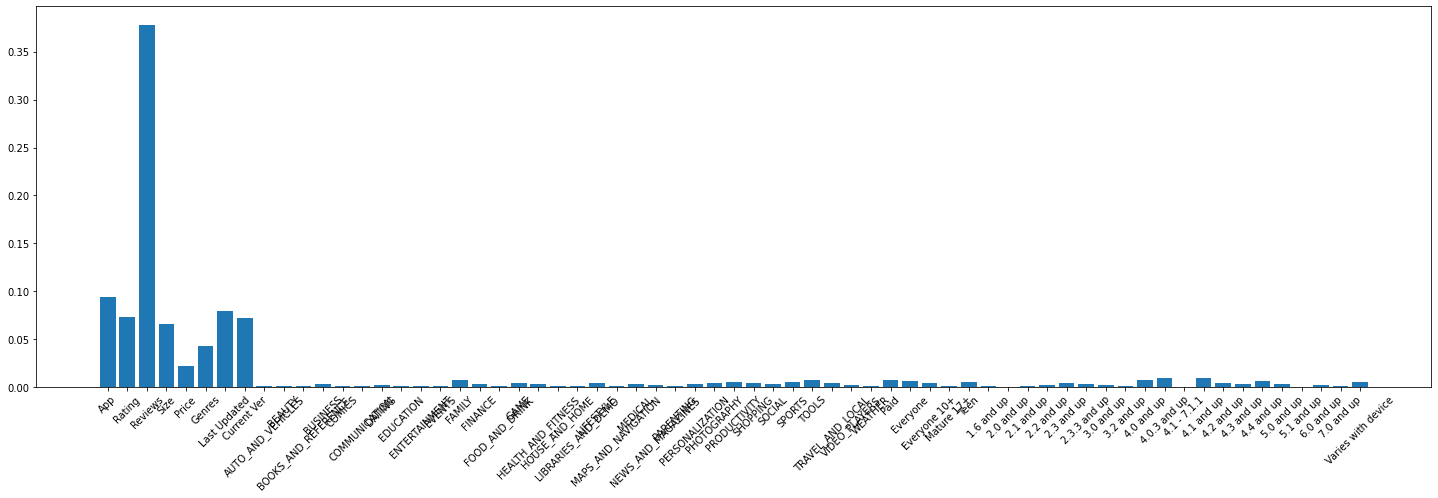

In [ ]:
x = range(len(y))
f, ax = plt.subplots(figsize=(25, 7))
plt.bar(x, y)
plt.xticks(x, y.index, rotation = 45)

In [ ]:
y.sort_values().iloc[-4:-1]

Rating          0.072856
Last Updated    0.079409
App             0.093436
dtype: float64

## 3.1. Продемонстрировать работу случайного леса RandomForestClassifier

In [ ]:
forest = RandomForestClassifier(n_estimators=20, random_state=17)
forest.fit(X_train_scaled, y_train)
print(classification_report(y_test, forest.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.50      0.20      0.29        15
           5       0.10      0.07      0.08        15
          10       0.33      0.43      0.37        89
          50       0.08      0.04      0.05        51
         100       0.41      0.53      0.46       178
         500       0.17      0.10      0.12        83
        1000       0.42      0.53      0.47       229
        5000       0.32      0.16      0.21       132
       10000       0.54      0.60      0.57       279
       50000       0.38      0.16      0.22       116
      100000       0.52      0.69      0.59       282
      500000       0.35      0.17      0.23       131
     1000000       0.64      0.80      0.71       395
     5000000       0.60      0.40      0.48       186
    10000000       0.73      0.78      0.75       329
    50000000       0.74      0.48      0.58        65
   100000000       0.93    

## 3.2. С помощью GridSearchCV произвести подбор гиперпараметров для поиск наилучшего леса, посмотреть насколько улучшились метрики

In [ ]:
forest_params = {
    'max_depth': range(1, 20),
    'max_features': range(3, 15)
}
forest_grid = GridSearchCV(forest, forest_params, cv=5)
forest_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=20, random_state=17),
             param_grid={'max_depth': range(1, 20),
                         'max_features': range(3, 15)})

In [ ]:
forest_grid.best_params_, forest_grid.best_score_ 

({'max_depth': 19, 'max_features': 14}, 0.5670356703567035)

In [ ]:
print(classification_report(y_test, forest_grid.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.50      0.13      0.21        15
           5       0.00      0.00      0.00        15
          10       0.34      0.39      0.36        89
          50       0.05      0.02      0.03        51
         100       0.45      0.58      0.51       178
         500       0.18      0.06      0.09        83
        1000       0.50      0.65      0.56       229
        5000       0.43      0.14      0.22       132
       10000       0.60      0.73      0.66       279
       50000       0.43      0.16      0.24       116
      100000       0.56      0.76      0.64       282
      500000       0.49      0.19      0.27       131
     1000000       0.64      0.82      0.72       395
     5000000       0.67      0.42      0.52       186
    10000000       0.75      0.83      0.78       329
    50000000       0.77      0.55      0.64        65
   100000000       0.90    

Таким образом, наибольшей точности предсказания получилось достичь при использовании RandomForestClassifier. Самый худший результат показал KNeighborsClassifier.